In [4]:
# Import libraries
%matplotlib inline

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pysal as ps
import geopandas as gpd
from sklearn import cluster
from sklearn.preprocessing import scale

sns.set(style="whitegrid")

In [9]:
# Import data
broker_data = 'data/Brokered2018_2021 2.csv'
zip_codes = 'data/ZipCodes.csv'

In [10]:
# Read data
lst = pd.read_csv(broker_data)

In [1]:
# Define variables
varis = ['Carrier', 'Customer']

In [ ]:
aves = lst.groupby('zipcode')[varis].mean()
aves.info()

In [ ]:
# 

In [ ]:
# Data grouping
types = pd.get_dummies(lst['property_type'])
prop_types = types.join(lst['zipcode'])\
                  .groupby('zipcode')\
                  .sum()
prop_types_pct = (prop_types * 100.).div(prop_types.sum(axis=1), axis=0)
prop_types_pct.info()

In [ ]:
aves_props = aves.join(prop_types_pct)

In [ ]:
db = pd.DataFrame(\
                 scale(aves_props), \
                 index=aves_props.index, \
                 columns=aves_props.columns)\
       .rename(lambda x: str(int(x)))

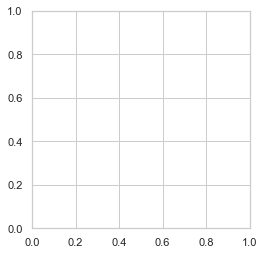

In [12]:
# Bring in geography
zc = gpd.read_file(zip_codes)
zc.plot(color='red');

In [ ]:
zdb = zc[['geometry', 'zipcode', 'name']].join(db, on='zipcode')\
                                         .dropna()

In [ ]:
#Cluster in specfic groups
km5 = cluster.KMeans(n_clusters=5)

In [ ]:
# Fit to data
km5cls = km5.fit(zdb.drop(['geometry', 'name'], axis=1).values)

In [ ]:
# Map clusters
f, ax = plt.subplots(1, figsize=(9, 9))

zdb.assign(cl=km5cls.labels_)\
   .plot(column='cl', categorical=True, legend=True, \
         linewidth=0.1, edgecolor='white', ax=ax)

ax.set_axis_off()

plt.show()

In [ ]:
# Attributes
cl_pcts = prop_types_pct.rename(lambda x: str(int(x)))\
                          .reindex(zdb['zipcode'])\
                          .assign(cl=km5cls.labels_)\
                          .groupby('cl')\
                          .mean()

In [ ]:
#Visualize attributes and mix
f, ax = plt.subplots(1, figsize=(18, 9))
cl_pcts.plot(kind='barh', stacked=True, ax=ax, \
             cmap='Set2', linewidth=0)
ax.legend(ncol=1, loc="right");